**This notebook accomplishes the following:**

- Imports the raw data (.csv), processes and writes it, or loads the previously processed and written data
- Writes a requirements.txt
- Concise DEA, by grouping similar columns together
- Explores the performance of basic outlier algorithms (Iso-forest and Mahalonobis) on the column groups
- Offers wrapper functions for outlier detection and visualization of results


## Settings

In [16]:
load_from_csv = False # Set to true to load .csv data and do some basic pre-processing (joining)
# Set to True the first time running this (make sure data is in /data)
n_rows = 200000 # Set to None to load all data (recommended: 200'000)

## Imports

In [2]:
import os
import gc
import pickle
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as preproc_scale
import plotly.express as px
%matplotlib inline
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Export the packages and versions to requirements.txt

In [3]:
# Code from Stackoverflow
# https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))
with open('requirements.txt', 'wt') as f:
    [f.write("{}=={}\n".format(*r)) for r in requirements]
    

seaborn==0.9.0
scikit-learn==0.20.2
plotly==4.3.0
pandas==0.23.4
numpy==1.17.2
matplotlib==3.0.2


## Function definitions

In [4]:
def train_test_isoF(X_train, y_train, X_test=None, y_test=None, max_samples=1024, feature_list=None):
    if not feature_list is None:
        X_train, X_test = X_train[feature_list], X_test[feature_list]
    ifo = IsolationForest(n_estimators=50, max_samples=max_samples)
    ifo.fit(X_train)
    y_pred_ifo = ifo.decision_function(X_train)
    print('AUC Score on Train: {:.3f}'.format(roc_auc_score(y_train, -y_pred_ifo)))
    if X_test is None:
        return ifo
    y_pred_ifo_test = ifo.decision_function(X_test)    
    print('AUC Score on Test: {:.3f}'.format(roc_auc_score(y_test, -y_pred_ifo_test)))
    return ifo


In [5]:
def median_imputation(df, median_impute_limit=0.95, impute_val=-999):
    """ inf/nan Values that occur more often than median_impute_limit are imputed with the median
    when less often, they are imputed by impute_val. 
    Set median_impute_limit to 0 to always do median imputation
    """
    df = df.replace([np.inf, -np.inf], np.nan)
    for col in df.columns:
        if not df[col].dtype == 'object':
            mean_nan = df[col].isna().mean()
            if mean_nan > median_impute_limit: # then, impute by median
                df[col] = df[col].fillna(df[col].median())
            elif mean_nan > 0 and mean_nan <= median_impute_limit:
                df[col] = df[col].fillna(impute_val)
                
    return df

In [6]:
def label_encoding(df, columns, test_df=None):
    # %%time
    for col in columns:
        le = LabelEncoder()
        if not test_df is None:
            le.fit(list(df[col].astype(str).values) + list(test_df[col].astype(str).values))          
            df[col] = le.transform(list(df[col].astype(str).values))
            test_df[col] = le.transform(list(test_df[col].astype(str).values)) 
        else:
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
    return df

In [7]:
def reduce_mem_usage(df, verbose=True):
    """ function from Kaggle. Transforms the column data types to the smallest possible representation
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                #if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                #    df[col] = df[col].astype(np.int8)
                #elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                #    df[col] = df[col].astype(np.int16)
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} to {:5.2f} Mb ({:.1f}% reduction)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



## Data loading and basic pre-processing

Data can be downloaded here: 

https://www.kaggle.com/c/ieee-fraud-detection

Note: there are two data sets that need to be joined: Transaction data, on which Identity data (which is oftentimes missing) is left-joined. 


**NB:** It might be clever to do an inner join between the tables, to get rid of all empty identity rows

Do this if this makes the results better. 

In [72]:
TRAIN_DATA_PATH = 'data/train.pkl'
TRAXCOLUMNS_PATH = 'data/trax_columns.pkl'
RAW_TRAX_DATA_PATH = 'data/train_transaction.csv'
RAW_ID_DATA_PATH = 'data/train_identity.csv'
LABEL_PATH = 'data/y_train.pkl'

if load_from_csv:
    # "Left table": load only n rows
    data_transaction = pd.read_csv(RAW_TRAX_DATA_PATH, nrows=n_rows)
    
    # "Right table": load all (to be sure nothing is missed)
    data_identity = pd.read_csv(RAW_ID_DATA_PATH)
    data_identity['has_id'] = 1 # to identify those that had identity info 
    
    train = data_transaction.merge(data_identity, on='TransactionID', how='left')
    train['has_id'] = train['has_id'].fillna(0)

    #identity_cols = data_identity.columns
    transaction_cols = pd.Series(data_transaction.columns)
    transaction_cols.to_pickle(TRAXCOLUMNS_PATH)
    del data_transaction, data_identity
    train = reduce_mem_usage(train)
    train.to_pickle(TRAIN_DATA_PATH)
    train.isFraud.to_pickle(LABEL_PATH) # y-labels
else:
    train = pd.read_pickle(TRAIN_DATA_PATH)
    
    transaction_cols = pd.read_pickle(TRAXCOLUMNS_PATH) 

print('train shape: {}'.format(train.shape))
print('Fraction of rows with ID data: {:.2%}'.format(train.has_id.mean()))
print('Number of positive samples: {} (fraction: {:.2%})'.format(train.isFraud.sum(),
                                                               train.isFraud.mean()))
train_y = train.isFraud
# train = train.drop('isFraud', axis=1)

train shape: (200000, 435)
Fraction of rows with ID data: 35.05%
Number of positive samples: 6024 (fraction: 3.01%)


## Data exploration

In [20]:
column_groups = {'card': [c for c in train.columns if c.startswith('card')],
                   'addr': [c for c in train.columns if c.startswith('addr')],
                   'dist1': ['dist1', 'dist2'],
                   'C' : [c for c in train.columns if c.startswith('C')],
                   'D' : [c for c in train.columns if c.lstrip('D').isnumeric()],
                   'M' : [c for c in train.columns if c.startswith('M')],
                   'id' : [c for c in train.columns if c.startswith('id')],   
                   'V': [c for c in train.columns if c.startswith('V')],
                   'trans': [c for c in train.columns if c.startswith('Trans')]}



In [21]:
allcols_in_groups = []
for col_group in column_groups.values():
    allcols_in_groups += col_group
    

In [22]:
set(train.columns) - set(allcols_in_groups)


{'DeviceInfo',
 'DeviceType',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'has_id'}

### Card Columns

From the Kaggle forum:

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

All categorical! (according to the competition host)


In [23]:
train.sample(5).loc[:, column_groups['card']]


,card1,card2,card3,card4,card5,card6
33174,9500,321.0,150.0,visa,226.0,debit
37301,12691,555.0,150.0,visa,226.0,debit
181264,13534,105.0,150.0,visa,226.0,debit
196457,12932,361.0,150.0,visa,226.0,debit
173624,18301,459.0,185.0,mastercard,224.0,credit


In [24]:
train.loc[:, column_groups['card']].nunique()


card1    9823
card2     499
card3      91
card4       4
card5      98
card6       4
dtype: int64

In [25]:
train.loc[:, column_groups['card']].isna().sum()


card1       0
card2    3026
card3       3
card4       9
card5    1067
card6       7
dtype: int64

In [26]:
card_encoded = label_encoding(train[column_groups['card']], column_groups['card'])

### Dist1  Column

dist: distance
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”


In [27]:
train[column_groups['dist1']].nunique()

dist1    2166
dist2    1282
dtype: int64

In [28]:
train[column_groups['dist1']].isna().mean()

dist1    0.658170
dist2    0.922405
dtype: float64

In [29]:
train[column_groups['dist1']].sample(5, random_state=11)

,dist1,dist2
126682,NaN,NaN
64852,12.0,NaN
139941,39.0,NaN
85091,NaN,16.0
61522,NaN,276.0


In [30]:
train[column_groups['dist1']].isna().mean()
dist_cols = pd.concat((train[['dist1']].fillna(train[['dist1']].median()), 
                        train[['dist1']].isna().astype(int).rename(columns={'dist1': 'dist1_nan'}),
                      train[['dist2']].fillna(train[['dist2']].median()), 
                        train[['dist2']].isna().astype(int).rename(columns={'dist2': 'dist2_nan'})), axis=1)

In [31]:
dist_cols.head()

,dist1,dist1_nan,dist2,dist2_nan
0,19.0,0,28.0,1
1,9.0,1,28.0,1
2,287.0,0,28.0,1
3,9.0,1,28.0,1
4,9.0,1,28.0,1


Observation: these fields are mostly empty. Indicator column was added for both


### Address Columns 


In [32]:
train.sample(10, random_state=1)[column_groups['addr']]


,addr1,addr2
49673,431.0,60.0
171551,NaN,NaN
5506,231.0,87.0
38370,441.0,87.0
36930,NaN,NaN
167783,181.0,87.0
67487,204.0,87.0
101486,299.0,87.0
131774,NaN,NaN
48246,310.0,87.0


In [33]:
train[column_groups['addr']].nunique()


addr1    273
addr2     57
dtype: int64

In [34]:
train[column_groups['addr']].isna().sum()
addr2 = train['addr2'].fillna(train['addr2'].mode()[0])

In [35]:
train['addr2'].mode()[0]

87.0

Observations:
- Indicator for missing values may be useful
- According to the description, these columns are categorical. Do not seem very useful


### C- columns

In [36]:
train[column_groups['C']].dtypes.value_counts()

float32    14
dtype: int64

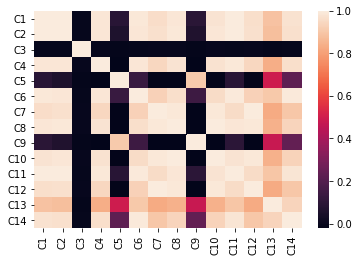

In [37]:
sns.heatmap(train[column_groups['C']].corr());

Do PCA on the C columns

In [38]:
C_original = preproc_scale(train[column_groups['C']])
pca = PCA(n_components=3)
C_transformed = pca.fit_transform(C_original)

var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) # NB: 3 variables is plenty


[75.47 90.85 97.99]


Observation: C columns can be effectively be represented by 3 PCA coefficients

### D- columns

D1-D15: timedelta, such as days between previous transaction, etc.

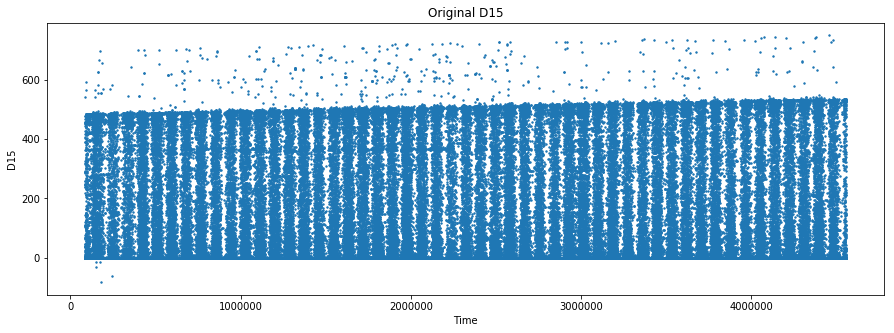

In [39]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(train.TransactionDT,train.D15, s=2)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [40]:
train[column_groups['D']].dtypes.value_counts()


float32    15
dtype: int64

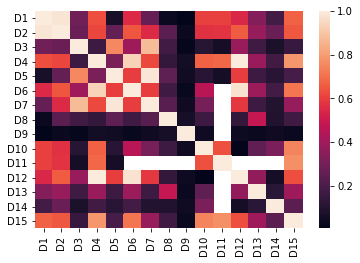

In [41]:
sns.heatmap(train[column_groups['D']].corr());

In [42]:
column_groups['D']

['D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15']

In [43]:
train[column_groups['D']].isna().sum()

D1          0
D2     108269
D3     104965
D4      77917
D5     121106
D6     173705
D7     187224
D8     164684
D9     164684
D10     47054
D11    133127
D12    177263
D13    179592
D14    177761
D15     50228
dtype: int64

In [44]:
D_imputed = median_imputation(train[column_groups['D']].copy(), median_impute_limit=0)
D_original = preproc_scale(D_imputed)

pca = PCA(n_components=10)
D_transformed = pca.fit_transform(D_original)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) # NB: 3 variables is plenty


[27.21 44.32 52.33 59.08 65.58 71.95 78.01 83.27 87.75 91.36]


Observation: D columns can be effectively be represented by 10 PCA coefficients (91%)

### V- columns

In [45]:
train[column_groups['V']].dtypes.value_counts()

float32    339
dtype: int64

In [46]:
train[column_groups['V']].max().value_counts().head(5)


7.0         28
101640.0    19
6.0         16
5.0         15
8.0         12
dtype: int64

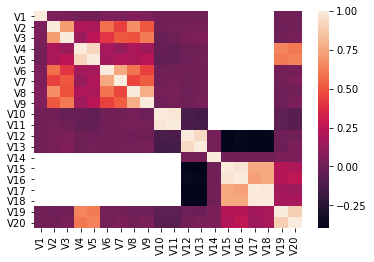

In [47]:
sns.heatmap(train[column_groups['V'][:20]].corr());

In [48]:
V_original = median_imputation(train[column_groups['V']], median_impute_limit=0)
V_original = preproc_scale(V_original)
pca = PCA(n_components=25, whiten=True)
V_transformed = pca.fit_transform(V_original)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 


[10.78 19.34 26.16 31.89 36.87 40.61 44.05 47.12 49.73 52.23 54.38 56.48
 58.47 60.18 61.84 63.34 64.69 65.89 67.02 68.09 69.11 70.08 71.02 71.94
 72.78]


In [49]:
train[column_groups['V']].isna().sum().unique()

array([133127,  47067,  77923,  47401,  50236,      0, 150642, 132413,
       135032, 131143,     11, 150464])

Do PCA on the "NaN-ness" of the columns

In [50]:
V_nans = train[column_groups['V']].isna().astype(int)
pca = PCA(n_components=3)
V_nans_transformed = pca.fit_transform(V_nans)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 

[78.09 89.4  93.13]


With merely 3 components, more than 90% of variance is explained. 

Observations: 
- There are about 330 V columns, with a lot of NaN's (~40% is missing)
- These can be compressed to about 25 PCA coefficients (75% explained variance) if they are median-imputed
- The rows with NaN's are equal for many V-columns
- The NaN-ness can be efficiently PCA-compressed to 3 columns (93%) or perfectly reconstructed with 10 components.


### M- columns

M1-M9: match, such as names on card and address, etc.
Categorical

In [51]:
train[column_groups['M']].nunique()


M1    2
M2    2
M3    2
M4    3
M5    2
M6    2
M7    2
M8    2
M9    2
dtype: int64

In [52]:
train[column_groups['M']].isna().sum()

M1    130475
M2    130475
M3    130475
M4    104946
M5    128469
M6     78424
M7    162910
M8    162910
M9    162910
dtype: int64

In [53]:
train[column_groups['M']].sample(10)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
131385,T,T,T,NaN,NaN,T,NaN,NaN,NaN
196386,T,F,F,M0,T,T,F,F,F
15123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11686,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN
42837,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN
75784,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
24096,T,T,T,NaN,NaN,F,NaN,NaN,NaN
127917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109312,T,T,T,NaN,NaN,T,F,F,F
167003,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN


In [54]:
M_encoded = label_encoding(train[column_groups['M']], column_groups['M'])

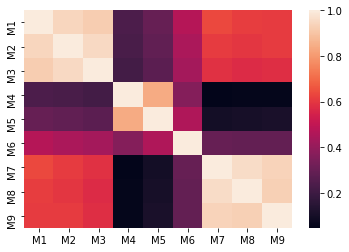

In [55]:
sns.heatmap(M_encoded.corr());

In [56]:
M_transformed = preproc_scale(M_encoded)
pca = PCA(n_components=3, whiten=True)
M_transformed = pca.fit_transform(M_transformed)
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1) 


[56.3  78.37 89.01]


In [57]:
train[column_groups['V']].isna().sum().unique()

array([133127,  47067,  77923,  47401,  50236,      0, 150642, 132413,
       135032, 131143,     11, 150464])

### Transaction columns

TransactionAMT: transaction payment amount in USD

“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

TransactionDT --> get the time in hours

In [59]:
column_groups['trans']


['TransactionID', 'TransactionDT', 'TransactionAmt']

In [60]:
transaction_hour = (train.TransactionDT % (60*60*24))/3600

In [61]:
train['addr2'].isna().sum()

21392

## Unsupervised Outlier Detection experiments


In [73]:
def plot_outlier_scores(scores):
    roc_score = roc_auc_score(train.isFraud, scores)
    classify_results = pd.DataFrame(data=pd.concat((train.isFraud, pd.Series(scores)), axis=1))
    classify_results.rename(columns={0:'score'}, inplace=True)
    sns.kdeplot(classify_results.loc[classify_results.isFraud==0, 'score'], label='negatives', shade=True, bw=0.01)
    sns.kdeplot(classify_results.loc[classify_results.isFraud==1, 'score'], label='positives', shade=True, bw=0.01)
    plt.title('AUC: {:.3f}'.format(roc_score))
    plt.xlabel('Score');
    return classify_results

In [74]:
def plot_top_N(scores, N=100):
    N = min(N, len(scores)) 
    classify_results = pd.DataFrame(data=pd.concat((train.isFraud, pd.Series(scores)), axis=1))
    classify_results.rename(columns={0:'score'}, inplace=True)
    classify_results = classify_results.sort_values(by='score', ascending=False)[:N]
    Npos_in_N = classify_results['isFraud'].sum()
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 2))
    ims = ax.imshow(np.reshape(classify_results.isFraud.values, [1, -1]), extent=[-0.5, N, N/50, -0.5])
    ax.yaxis.set_visible(False)
    # ax.xaxis.set_ticklabels
    plt.colorbar(ims)    
    plt.xlabel('Outlier rank [-]')
    plt.title(f'Number of positives found: {Npos_in_N} (P@Rank{N}: {Npos_in_N/N:.1%})')
    #plt.show()
    return classify_results    

### 1) Time and Region

In [75]:
cmap = plt.cm.get_cmap('YlOrRd')

In [76]:
#### Hour and Region
X_hour_region = pd.concat((transaction_hour, addr2), axis=1)
isof = train_test_isoF(X_hour_region, train_y)
scores = - isof.decision_function(X_hour_region)


AUC Score on Train: 0.552


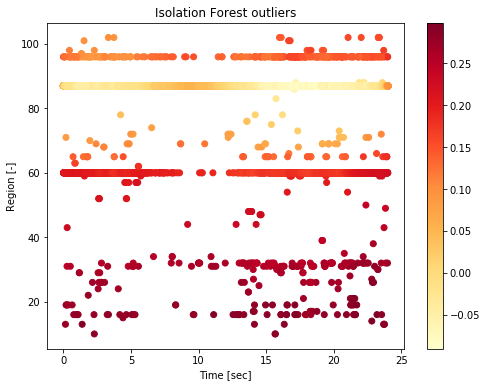

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc = plt.scatter(transaction_hour, addr2, c=scores, cmap=cmap)
fig.colorbar(sc)
plt.title('Isolation Forest outliers')
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Region [-]')
plt.show()


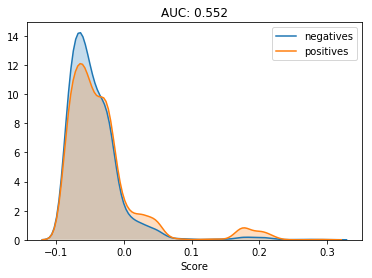

In [78]:
res = plot_outlier_scores(scores)

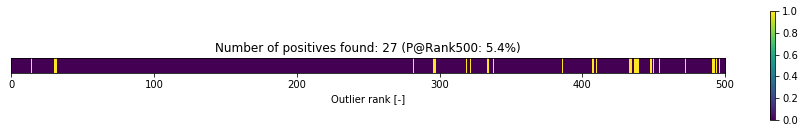

In [79]:
res = plot_top_N(scores, N=500)

Conclusion: Hour and region "mismatches" are only a weak indicator for fraud.


### 2) V columns

** 1. Untransformed ** 

In [80]:
isof = train_test_isoF(V_original, train.isFraud)
scores = - isof.decision_function(V_original)


AUC Score on Train: 0.751


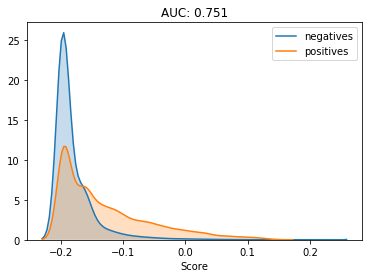

In [81]:
classify_results = plot_outlier_scores(scores)

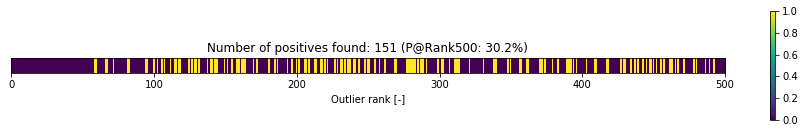

In [83]:
res = plot_top_N(scores, N=500)

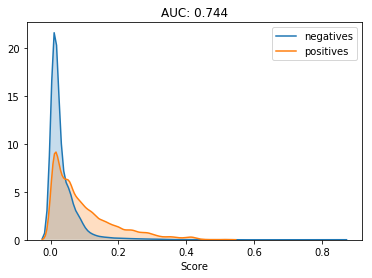

In [85]:
distance_score = np.mean(V_original ** 2, axis=1)
distance_score = np.log(1 + distance_score)  / 10
classify_results = plot_outlier_scores(distance_score)

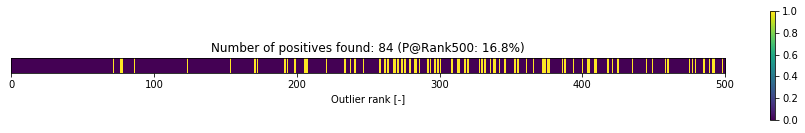

In [86]:
res = plot_top_N(distance_score, N=500)

** 2. PCA Transformed ** 

In [87]:
isof = train_test_isoF(V_transformed, train.isFraud)
scores = - isof.decision_function(V_transformed)


AUC Score on Train: 0.736


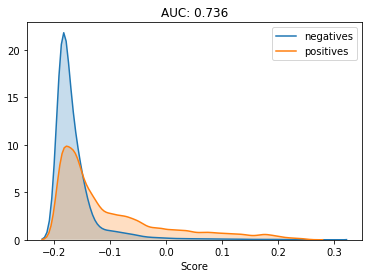

In [88]:
classify_results = plot_outlier_scores(scores)

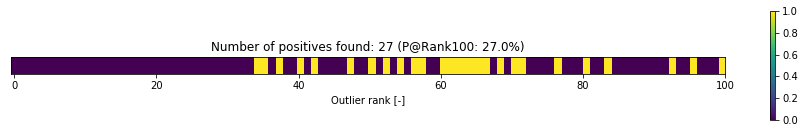

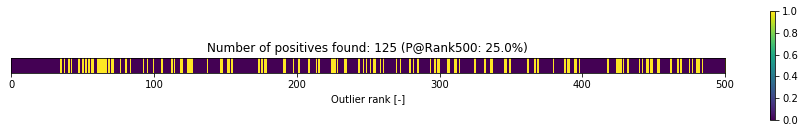

In [90]:
res = plot_top_N(scores, N=100)
res = plot_top_N(scores, N=500)
#res = plot_top_N(scores, N=2500)

Alternative: calculate the Mahalonobis distance

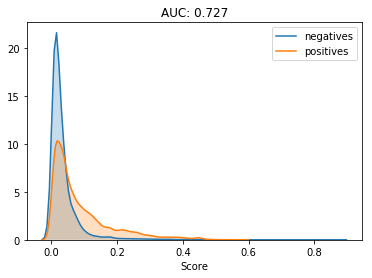

In [91]:
maha_score = np.mean(V_transformed ** 2, axis=1)
maha_score = np.log(1 + maha_score)  / 10
classify_results = plot_outlier_scores(maha_score)

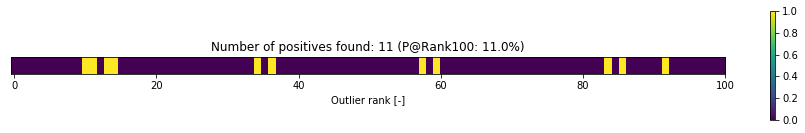

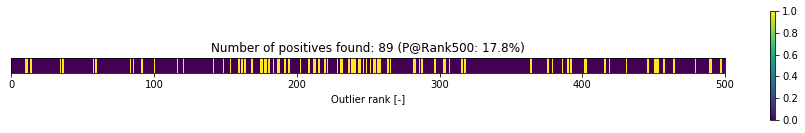

In [93]:
res = plot_top_N(maha_score, N=100)
res = plot_top_N(maha_score, N=500)
#res = plot_top_N(maha_score, N=10000)

### 2) V-nan columns

In [94]:
isof = train_test_isoF(V_nans, train.isFraud)
scores = - isof.decision_function(V_nans)


AUC Score on Train: 0.573


In [ ]:
isof = train_test_isoF(V_nans_transformed, train.isFraud)
scores = - isof.decision_function(V_nans_transformed)

### 3) C-columns

In [95]:
isof = train_test_isoF(train[column_groups['C']], train.isFraud)
# scores = - isof.decision_function(C_transformed)

AUC Score on Train: 0.691


In [ ]:
isof = train_test_isoF(C_transformed, train.isFraud)
#scores = - isof.decision_function(C_transformed)

### 4) M-columns (categorical)


In [96]:
isof = train_test_isoF(M_encoded, train.isFraud)
scores = - isof.decision_function(M_encoded)

AUC Score on Train: 0.453


In [ ]:
isof = train_test_isoF(M_transformed, train.isFraud)
scores = - isof.decision_function(M_transformed)

### 5) card-columns (categorical)


** 1. All columns **

In [97]:
isof = train_test_isoF(card_encoded, train.isFraud)
scores = - isof.decision_function(card_encoded)


AUC Score on Train: 0.629


In [ ]:
classify_results = plot_outlier_scores(scores)

** 2. All but first column **

In [98]:
isof = train_test_isoF(card_encoded.iloc[:, 1:], train.isFraud)
scores = - isof.decision_function(card_encoded.iloc[:, 1:])

AUC Score on Train: 0.621


In [ ]:
classify_results = plot_outlier_scores(scores)

### 6) Combining the best groups

In [99]:
data_combined = np.concatenate((V_transformed, card_encoded.iloc[:, 1:].values, 
                                train[column_groups['C']]), axis=1)

In [100]:
isof = train_test_isoF(data_combined, train.isFraud)
scores = - isof.decision_function(data_combined)

AUC Score on Train: 0.732


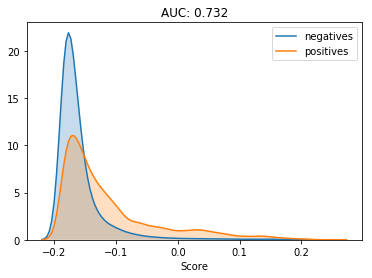

In [101]:
classify_results = plot_outlier_scores(scores)

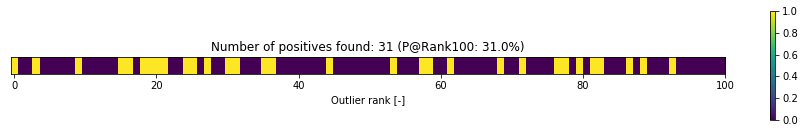

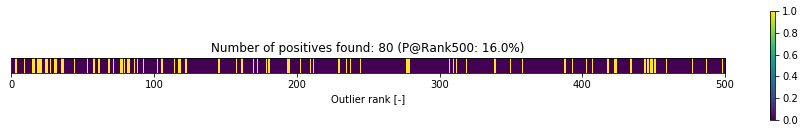

In [102]:
res = plot_top_N(scores, N=100)
res = plot_top_N(scores, N=500)
# res = plot_top_N(scores, N=10000)